In [1]:
import pandas as pd
import numpy as np

C:\Users\shubh\AppData\Local\Temp\ipykernel_25888\2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")

df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")

df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

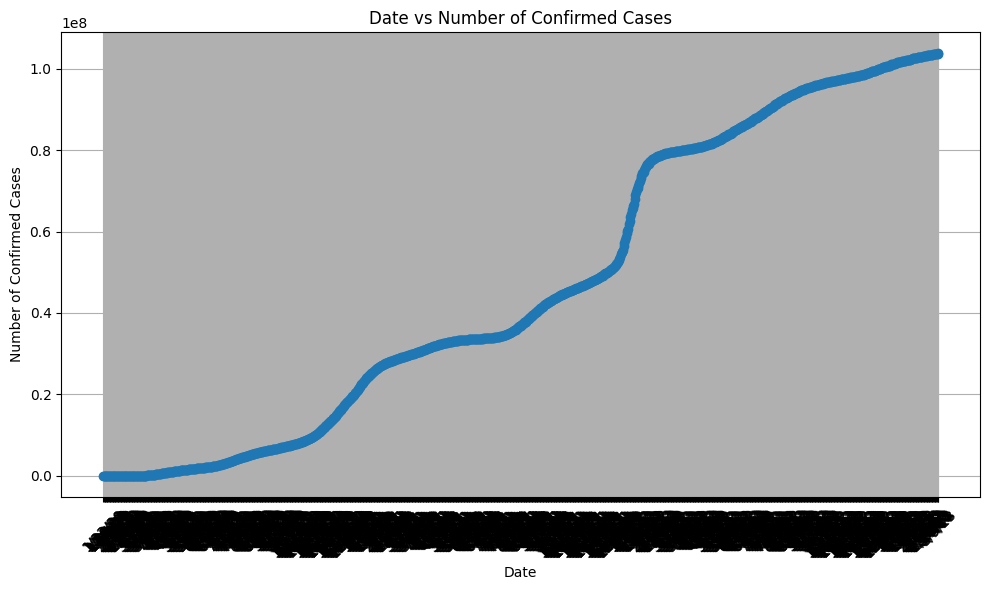

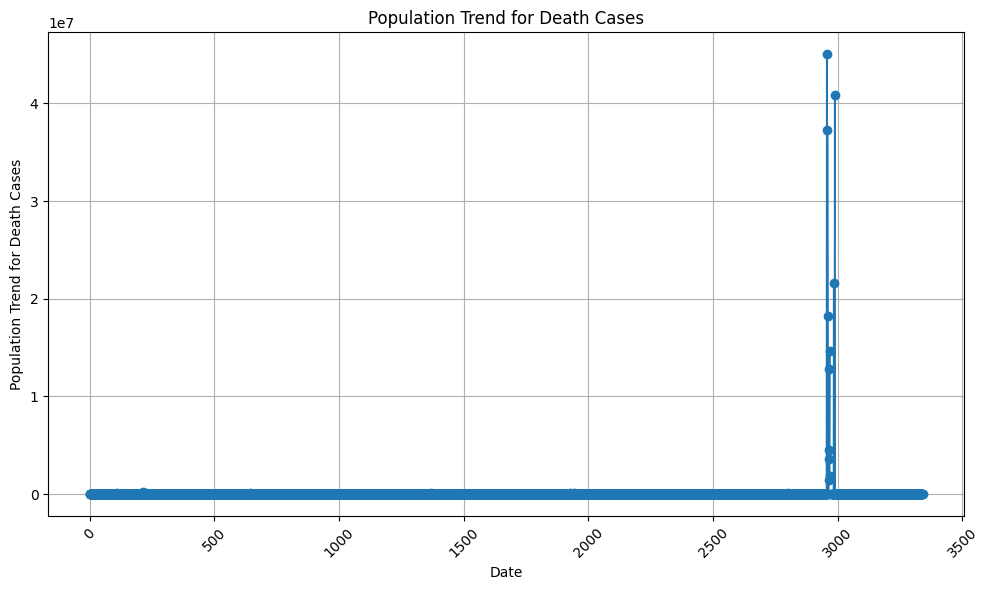

In [3]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Preprocess data
# For geospatial visualization, we need to aggregate the confirmed cases by state
df_confirmed_by_state = df_confirmed_cases.groupby("Province_State").sum().reset_index()

# Calculate population trend for death cases using the "Population" column from df_deaths
# Handle non-numeric values when summing the columns
df_deaths_numeric = df_deaths.drop(columns=["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Province_State", "Country_Region", "Lat", "Long_", "Combined_Key"])
df_deaths_numeric = df_deaths_numeric.apply(pd.to_numeric, errors='coerce')
df_deaths_numeric = df_deaths_numeric.fillna(0)  # Replace NaNs with 0
df_confirmed_numeric = df_confirmed_cases.drop(columns=["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Province_State", "Country_Region", "Lat", "Long_", "Combined_Key"])
df_confirmed_numeric = df_confirmed_numeric.apply(pd.to_numeric, errors='coerce')
df_confirmed_numeric = df_confirmed_numeric.fillna(0)  # Replace NaNs with 0
df_deaths["Population_trend"] = df_deaths["Population"] * (df_deaths_numeric.sum(axis=1) / df_confirmed_numeric.sum(axis=1))

# Create a Folium map
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add markers to the map with radius based on confirmed cases
marker_cluster = MarkerCluster().add_to(m)
for idx, row in df_confirmed_by_state.iterrows():
    state = row["Province_State"]
    cases = row[df_confirmed_cases.columns[11:]].sum()  # Summing confirmed cases from date columns
    radius = min(cases / 10000, 50)  # Scale radius to fit within reasonable bounds
    folium.CircleMarker(location=[row["Lat"], row["Long_"]], radius=radius, color='blue', fill=True).add_to(marker_cluster)

# Color states based on total number of cases
choropleth = folium.Choropleth(
    geo_data='https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json',
    data=df_confirmed_by_state,
    columns=['Province_State', df_confirmed_cases.columns[11]],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Confirmed Cases'
).add_to(m)

# Create line plot for Date vs Number of Confirmed Cases
dates = df_confirmed_cases.columns[11:]
confirmed_cases = df_confirmed_cases[dates].sum()

plt.figure(figsize=(10, 6))
plt.plot(dates, confirmed_cases, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Confirmed Cases')
plt.title('Date vs Number of Confirmed Cases')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Create line plot for Population Trend for Death Cases
plt.figure(figsize=(10, 6))
plt.plot(df_deaths["Population_trend"], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Population Trend for Death Cases')
plt.title('Population Trend for Death Cases')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import folium

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to create map with markers
def create_map():
    # Create a Folium map
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Add markers for each location
    for index, row in df_deaths.iterrows():
        # Get coordinates
        lat = row['Lat']
        lon = row['Long_']
        
        # Create marker with popup
        popup_html = f"<b>Location:</b> {row['Combined_Key']}<br>"
        popup_html += f"<b>Total Deaths:</b> {row.iloc[12:].sum()}<br>"
        popup_html += f"<b>Total Vaccinations:</b> {df_vaccinations[df_vaccinations['location'] == row['Province_State']]['total_vaccinations'].max()}<br>"
        popup_html += f"<b>Other aspects:</b> ...<br>"  # Add other aspects as needed
        
        folium.Marker([lat, lon], popup=folium.Popup(popup_html, parse_html=True)).add_to(m)
    
    return m

# Create and display the map
map_with_markers = create_map()
map_with_markers.save('map_with_markers.html')
map_with_markers


In [6]:
import pandas as pd
import folium
from ipywidgets import interact, widgets

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to create map with markers
def create_map(min_deaths, max_deaths, min_vaccinations, max_vaccinations):
    # Create a Folium map
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Add markers for each location based on the filter criteria
    for index, row in df_deaths.iterrows():
        total_deaths = row.iloc[12:].sum()
        total_vaccinations = df_vaccinations[df_vaccinations['location'] == row['Province_State']]['total_vaccinations'].max()
        
        if min_deaths <= total_deaths <= max_deaths and min_vaccinations <= total_vaccinations <= max_vaccinations:
            # Get coordinates
            lat = row['Lat']
            lon = row['Long_']

            # Create marker with popup
            popup_html = f"<b>Location:</b> {row['Combined_Key']}<br>"
            popup_html += f"<b>Total Deaths:</b> {total_deaths}<br>"
            popup_html += f"<b>Total Vaccinations:</b> {total_vaccinations}<br>"
            popup_html += f"<b>Other aspects:</b> ...<br>"  # Add other aspects as needed

            folium.Marker([lat, lon], popup=folium.Popup(popup_html, parse_html=True)).add_to(m)
    
    return m

# Define the range for deaths and vaccinations
min_deaths = df_deaths.iloc[:, 12:].sum().min()
max_deaths = df_deaths.iloc[:, 12:].sum().max()
min_vaccinations = df_vaccinations['total_vaccinations'].min()
max_vaccinations = df_vaccinations['total_vaccinations'].max()

# Create the interactive map
interact(create_map, 
         min_deaths=widgets.IntSlider(min=min_deaths, max=max_deaths, step=1000, value=min_deaths, description='Min Deaths:'),
         max_deaths=widgets.IntSlider(min=min_deaths, max=max_deaths, step=1000, value=max_deaths, description='Max Deaths:'),
         min_vaccinations=widgets.IntSlider(min=min_vaccinations, max=max_vaccinations, step=1000, value=min_vaccinations, description='Min Vaccinations:'),
         max_vaccinations=widgets.IntSlider(min=min_vaccinations, max=max_vaccinations, step=1000, value=max_vaccinations, description='Max Vaccinations:')
        )


interactive(children=(IntSlider(value=1, description='Min Deaths:', max=1123836, min=1, step=1000), IntSlider(…

<function __main__.create_map(min_deaths, max_deaths, min_vaccinations, max_vaccinations)>

In [7]:
# #### BASED on STATES

# import pandas as pd
# import folium
# from ipywidgets import interact, widgets

# # Load datasets
# df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
# df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
# df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# # Function to create map with markers
# def create_map(min_deaths, max_deaths, min_vaccinations, max_vaccinations):
#     # Create a Folium map
#     m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

#     # Group data by states and calculate totals
#     df_deaths_by_state = df_deaths.groupby("Province_State").sum().reset_index()
#     df_vaccinations_by_state = df_vaccinations.groupby("location").max().reset_index()

#     # Merge deaths and vaccinations data
#     df_totals = pd.merge(df_deaths_by_state[["Province_State", "Combined_Key", "Lat", "Long_", "Population"]], 
#                          df_vaccinations_by_state[["location", "total_vaccinations"]], 
#                          left_on="Province_State", right_on="location", how="inner")

#     # # Add markers for each state based on the filter criteria
#     # for index, row in df_totals.iterrows():
#     #     total_deaths = row.iloc[5:-1].sum()
#     #     total_vaccinations = row['total_vaccinations']

#     #     if min_deaths <= total_deaths <= max_deaths and min_vaccinations <= total_vaccinations <= max_vaccinations:
#     #         # Get coordinates
#     #         lat = row['Lat']
#     #         lon = row['Long_']

#     #         # Create marker with popup
#     #         popup_html = f"<b>Location:</b> {row['Combined_Key']}<br>"
#     #         popup_html += f"<b>Total Deaths:</b> {total_deaths}<br>"
#     #         popup_html += f"<b>Total Vaccinations:</b> {total_vaccinations}<br>"
#     #         popup_html += f"<b>Other aspects:</b> ...<br>"  # Add other aspects as needed

#     #         folium.Marker([lat, lon], popup=folium.Popup(popup_html, parse_html=True)).add_to(m)

#     # return m

#     # Convert total_vaccinations to numeric
#     df_totals['total_vaccinations'] = pd.to_numeric(df_totals['total_vaccinations'], errors='coerce')

#     # Add markers for each state based on the filter criteria
#     for index, row in df_totals.iterrows():
#         total_deaths = row.iloc[5:-1].sum()
#         total_vaccinations = row['total_vaccinations']

#         if min_deaths <= total_deaths <= max_deaths and min_vaccinations <= total_vaccinations <= max_vaccinations:
#             # Get coordinates
#             lat = row['Lat']
#             lon = row['Long_']

#             # Create marker with popup
#             popup_html = f"<b>Location:</b> {row['Combined_Key']}<br>"
#             popup_html += f"<b>Total Deaths:</b> {total_deaths}<br>"
#             popup_html += f"<b>Total Vaccinations:</b> {total_vaccinations}<br>"
#             popup_html += f"<b>Other aspects:</b> ...<br>"  # Add other aspects as needed

#             folium.Marker([lat, lon], popup=folium.Popup(popup_html, parse_html=True)).add_to(m)
#     return m 

# # Define the range for deaths and vaccinations
# min_deaths = df_deaths.iloc[:, 12:].sum().min()
# max_deaths = df_deaths.iloc[:, 12:].sum().max()
# min_vaccinations = df_vaccinations['total_vaccinations'].min()
# max_vaccinations = df_vaccinations['total_vaccinations'].max()

# # Create the interactive map
# interact(create_map, 
#          min_deaths=widgets.IntSlider(min=min_deaths, max=max_deaths, step=1000, value=min_deaths, description='Min Deaths:'),
#          max_deaths=widgets.IntSlider(min=min_deaths, max=max_deaths, step=1000, value=max_deaths, description='Max Deaths:'),
#          min_vaccinations=widgets.IntSlider(min=min_vaccinations, max=max_vaccinations, step=1000, value=min_vaccinations, description='Min Vaccinations:'),
#          max_vaccinations=widgets.IntSlider(min=min_vaccinations, max=max_vaccinations, step=1000, value=max_vaccinations, description='Max Vaccinations:')
#         )


interactive(children=(IntSlider(value=1, description='Min Deaths:', max=1123836, min=1, step=1000), IntSlider(…

<function __main__.create_map(min_deaths, max_deaths, min_vaccinations, max_vaccinations)>

In [8]:
import pandas as pd
import folium
from ipywidgets import interact, widgets

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to create map with markers
def create_map(min_deaths, max_deaths, min_vaccinations, max_vaccinations):
    # Create a Folium map
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Convert total_vaccinations to numeric
    df_vaccinations['total_vaccinations'] = pd.to_numeric(df_vaccinations['total_vaccinations'], errors='coerce')

    # Add markers for each state based on the filter criteria
    for index, row in df_deaths.iterrows():
        total_deaths = row.iloc[12:].sum()
        total_vaccinations = df_vaccinations[df_vaccinations['location'] == row['Province_State']]['total_vaccinations'].max()

        if pd.notnull(total_vaccinations):  # Check if total_vaccinations is not null
            if min_deaths <= total_deaths <= max_deaths and min_vaccinations <= total_vaccinations <= max_vaccinations:
                # Get coordinates
                lat = row['Lat']
                lon = row['Long_']

                # Create marker with popup
                popup_html = f"<b>Location:</b> {row['Combined_Key']}<br>"
                popup_html += f"<b>Total Deaths:</b> {total_deaths}<br>"
                popup_html += f"<b>Total Vaccinations:</b> {total_vaccinations}<br>"
                popup_html += f"<b>Other aspects:</b> ...<br>"  # Add other aspects as needed

                folium.Marker([lat, lon], popup=folium.Popup(popup_html, parse_html=True)).add_to(m)

    return m

# Define the range for deaths and vaccinations
min_deaths = df_deaths.iloc[:, 12:].sum().min()
max_deaths = df_deaths.iloc[:, 12:].sum().max()
min_vaccinations = df_vaccinations['total_vaccinations'].min()
max_vaccinations = df_vaccinations['total_vaccinations'].max()

# Create the interactive map
interact(create_map, 
         min_deaths=widgets.IntSlider(min=min_deaths, max=max_deaths, step=1000, value=min_deaths, description='Min Deaths:'),
         max_deaths=widgets.IntSlider(min=min_deaths, max=max_deaths, step=1000, value=max_deaths, description='Max Deaths:'),
         min_vaccinations=widgets.IntSlider(min=min_vaccinations, max=max_vaccinations, step=1000, value=min_vaccinations, description='Min Vaccinations:'),
         max_vaccinations=widgets.IntSlider(min=min_vaccinations, max=max_vaccinations, step=1000, value=max_vaccinations, description='Max Vaccinations:')
        )


interactive(children=(IntSlider(value=1, description='Min Deaths:', max=1123836, min=1, step=1000), IntSlider(…

<function __main__.create_map(min_deaths, max_deaths, min_vaccinations, max_vaccinations)>

In [9]:
import folium
import urllib.request

# Download the GeoJSON file
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'
urllib.request.urlretrieve(url, 'us-states.json')


# Create a choropleth map for total confirmed cases
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
folium.Choropleth(
    geo_data='us-states.json',  # GeoJSON file containing state boundaries
    name='choropleth',
    data=df_confirmed_cases,
    columns=['Province_State', df_confirmed_cases.columns[11]],  # Use the latest date column
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Confirmed Cases'
).add_to(m)
folium.LayerControl().add_to(m)
m.save('choropleth_map.html')


In [10]:
import pandas as pd
import folium

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Create a choropleth map for total confirmed cases
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
folium.Choropleth(
    geo_data='us-states.json',  # GeoJSON file containing state boundaries
    name='choropleth',
    data=df_confirmed_cases,
    columns=['Province_State', df_confirmed_cases.columns[-1]],  # Use the latest date column
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Confirmed Cases'
).add_to(m)
folium.LayerControl().add_to(m)
m.save('choropleth_map.html')


In [11]:
import pandas as pd
import folium
from ipywidgets import interact, widgets

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to create choropleth map
def create_choropleth_map(data_type):
    # Choose the dataset based on the selected data type
    if data_type == 'Confirmed Cases':
        df = df_confirmed_cases
        column = df.columns[-1]  # Use the latest date column
        legend_name = 'Total Confirmed Cases'
    elif data_type == 'Deaths':
        df = df_deaths
        column = df.columns[-1]  # Use the latest date column
        legend_name = 'Total Deaths'
    elif data_type == 'Vaccinations':
        df = df_vaccinations
        column = 'total_vaccinations'
        legend_name = 'Total Vaccinations'

    # Create a choropleth map
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
    folium.Choropleth(
        geo_data='us-states.json',  # GeoJSON file containing state boundaries
        name='choropleth',
        data=df,
        columns=['Province_State', column],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(m)
    folium.LayerControl().add_to(m)
    return m

# Create the interactive map
interact(create_choropleth_map, data_type=['Confirmed Cases', 'Deaths', 'Vaccinations'])


interactive(children=(Dropdown(description='data_type', options=('Confirmed Cases', 'Deaths', 'Vaccinations'),…

<function __main__.create_choropleth_map(data_type)>

In [12]:

print(df_vaccinations.columns)



Index(['date', 'location', 'total_vaccinations', 'total_distributed',
       'people_vaccinated', 'people_fully_vaccinated_per_hundred',
       'total_vaccinations_per_hundred', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'distributed_per_hundred',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'daily_vaccinations_per_million', 'share_doses_used', 'total_boosters',
       'total_boosters_per_hundred'],
      dtype='object')


In [13]:
import pandas as pd
import folium
from ipywidgets import interact, widgets

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to create choropleth map
def create_choropleth_map(data_type):
    # Choose the dataset based on the selected data type
    if data_type == 'Confirmed Cases':
        df = df_confirmed_cases
        column = df.columns[-1]  # Use the latest date column
        legend_name = 'Total Confirmed Cases'
    elif data_type == 'Deaths':
        df = df_deaths
        column = df.columns[-1]  # Use the latest date column
        legend_name = 'Total Deaths'
    elif data_type == 'Vaccinations':
        df = df_vaccinations
        column = 'total_vaccinations'
        legend_name = 'Total Vaccinations'

    # Create a choropleth map
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
    folium.Choropleth(
        geo_data='us-states.json',  # GeoJSON file containing state boundaries
        name='choropleth',
        data=df,
        columns=['Province_State', column],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(m)
    
    # Add popup information for each state
    for state in df['Province_State']:
        state_data = df[df['Province_State'] == state]
        popup_html = f"<b>State:</b> {state}<br>"
        popup_html += f"<b>{legend_name}:</b> {state_data[column].values[0]}<br>"
        folium.Marker([state_data['Lat'].values[0], state_data['Long_'].values[0]], popup=popup_html).add_to(m)
    
    folium.LayerControl().add_to(m)
    return m

# Create the interactive map
interact(create_choropleth_map, data_type=['Confirmed Cases', 'Deaths', 'Vaccinations'])


interactive(children=(Dropdown(description='data_type', options=('Confirmed Cases', 'Deaths', 'Vaccinations'),…

<function __main__.create_choropleth_map(data_type)>

In [14]:
import pandas as pd
import folium
from ipywidgets import interact, widgets

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to calculate total deaths
def calculate_total_deaths():
    # Sum the values across all date columns
    total_deaths = df_deaths.iloc[:, 12:].sum(axis=1)
    # Add the total deaths as a new column
    df_deaths['Total Deaths'] = total_deaths
    return df_deaths

# Function to calculate total vaccinations
def calculate_total_vaccinations():
    # Group by location and sum the total_vaccinations
    total_vaccinations = df_vaccinations.groupby('location')['total_vaccinations'].max()
    return total_vaccinations

# Function to create choropleth map
def create_choropleth_map(data_type):
    # Choose the dataset based on the selected data type
    if data_type == 'Confirmed Cases':
        df = df_confirmed_cases
        column = df.columns[-1]  # Use the latest date column
        legend_name = 'Total Confirmed Cases'
    elif data_type == 'Deaths':
        df = calculate_total_deaths()
        column = 'Total Deaths'
        legend_name = 'Total Deaths'
    elif data_type == 'Vaccinations':
        df = calculate_total_vaccinations()
        column = df
        legend_name = 'Total Vaccinations'

    # Create a choropleth map
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
    folium.Choropleth(
        geo_data='us-states.json',  # GeoJSON file containing state boundaries
        name='choropleth',
        data=df,
        columns=['Province_State', column],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(m)
    
    # Add popup info for each state
    for idx, row in df.iterrows():
        state_info = f"<b>{row['Province_State']}</b><br>"
        state_info += f"{legend_name}: {row[column]}"
        folium.Marker(location=[row['Lat'], row['Long_']], popup=state_info).add_to(m)
    
    folium.LayerControl().add_to(m)
    return m

# Create the interactive map
interact(create_choropleth_map, data_type=['Confirmed Cases', 'Deaths', 'Vaccinations'])


interactive(children=(Dropdown(description='data_type', options=('Confirmed Cases', 'Deaths', 'Vaccinations'),…

<function __main__.create_choropleth_map(data_type)>

In [15]:
import pandas as pd

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to calculate total deaths for each state
def calculate_total_deaths():
    # Sum the values across all date columns for each state
    total_deaths = df_deaths.groupby('Province_State').sum().iloc[:, 11:].sum(axis=1)
    return total_deaths

# Function to calculate total confirmed cases for each state
def calculate_total_cases():
    # Sum the values across all date columns for each state
    total_cases = df_confirmed_cases.groupby('Province_State').sum().iloc[:, 11:].sum(axis=1)
    return total_cases

# Function to calculate total vaccinations for each state
def calculate_total_vaccinations():
    # Group by location and sum the total_vaccinations
    total_vaccinations = df_vaccinations.groupby('location')['total_vaccinations'].max()
    return total_vaccinations

# Calculate total deaths, cases, and vaccinations for each state
total_deaths = calculate_total_deaths()
total_cases = calculate_total_cases()
total_vaccinations = calculate_total_vaccinations()

# Display the results
print("Total Deaths by State:")
print(total_deaths)
print("\nTotal Confirmed Cases by State:")
print(total_cases)
print("\nTotal Vaccinations by State:")
print(total_vaccinations)


Total Deaths by State:
Province_State
Alabama                     13398261
Alaska                        751555
American Samoa                 10804
Arizona                     20789702
Arkansas                     7721989
California                  65490302
Colorado                     8942186
Connecticut                  8911110
Delaware                     2089142
Diamond Princess                   0
District of Columbia         1140001
Florida                     51475342
Georgia                     26228841
Grand Princess                  3209
Guam                          232819
Hawaii                        922359
Idaho                        3184340
Illinois                    28240376
Indiana                     16571222
Iowa                         6801602
Kansas                       6010896
Kentucky                     9906514
Louisiana                   12995598
Maine                        1420548
Maryland                    10814209
Massachusetts               16471102


In [16]:
import pandas as pd
import folium
from ipywidgets import interact, widgets

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to calculate total deaths
def calculate_total_deaths():
    # Sum the values across all date columns
    total_deaths = df_deaths.iloc[:, 12:].sum(axis=1)
    # Add the total deaths as a new column
    df_deaths['Total Deaths'] = total_deaths
    return df_deaths

# Function to calculate total vaccinations
def calculate_total_vaccinations():
    # Group by location and sum the total_vaccinations
    total_vaccinations = df_vaccinations.groupby('location')['total_vaccinations'].max()
    return total_vaccinations

# Function to create choropleth map
def create_choropleth_map(data_type):
    # Choose the dataset based on the selected data type
    if data_type == 'Confirmed Cases':
        df = df_confirmed_cases
        column = df.columns[-1]  # Use the latest date column
        legend_name = 'Total Confirmed Cases'
    elif data_type == 'Deaths':
        df = calculate_total_deaths()
        column = 'Total Deaths'
        legend_name = 'Total Deaths'
    elif data_type == 'Vaccinations':
        df = calculate_total_vaccinations().reset_index()  # Reset index to include 'location' as a column
        column = 'total_vaccinations'
        legend_name = 'Total Vaccinations'

    # Create a choropleth map
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
    folium.Choropleth(
        geo_data='us-states.json',  # GeoJSON file containing state boundaries
        name='choropleth',
        data=df,
        columns=['Province_State', column],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(m)
    
    # Add popup info for each state
    for idx, row in df.iterrows():
        state_info = f"<b>{row['Province_State']}</b><br>"
        state_info += f"{legend_name}: {row[column]}"
        folium.Marker(location=[row['Lat'], row['Long_']], popup=folium.Popup(state_info, parse_html=True)).add_to(m)
    
    folium.LayerControl().add_to(m)
    return m

# Create the interactive map
interact(create_choropleth_map, data_type=['Confirmed Cases', 'Deaths', 'Vaccinations'])


interactive(children=(Dropdown(description='data_type', options=('Confirmed Cases', 'Deaths', 'Vaccinations'),…

<function __main__.create_choropleth_map(data_type)>

In [17]:
## combining all province

import pandas as pd
import folium
from ipywidgets import interact, widgets

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to calculate total deaths
def calculate_total_deaths():
    # Sum the values across all date columns and group by Province_State
    total_deaths = df_deaths.iloc[:, 12:].sum(axis=1)
    df_deaths['Total Deaths'] = total_deaths
    total_deaths_by_state = df_deaths.groupby('Province_State')['Total Deaths'].sum().reset_index()
    return total_deaths_by_state

# Function to calculate total vaccinations
def calculate_total_vaccinations():
    # Group by location and sum the total_vaccinations
    total_vaccinations = df_vaccinations.groupby('location')['total_vaccinations'].max().reset_index()
    total_vaccinations.rename(columns={'location': 'Province_State'}, inplace=True)
    return total_vaccinations

# Function to create choropleth map
def create_choropleth_map(data_type):
    # Choose the dataset based on the selected data type
    if data_type == 'Confirmed Cases':
        df = df_confirmed_cases
        column = df.columns[-1]  # Use the latest date column
        legend_name = 'Total Confirmed Cases'
    elif data_type == 'Deaths':
        df = calculate_total_deaths()
        column = 'Total Deaths'
        legend_name = 'Total Deaths'
    elif data_type == 'Vaccinations':
        df = calculate_total_vaccinations()
        column = 'total_vaccinations'
        legend_name = 'Total Vaccinations'

    # Create a choropleth map
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
    folium.Choropleth(
        geo_data='us-states.json',  # GeoJSON file containing state boundaries
        name='choropleth',
        data=df,
        columns=['Province_State', column],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
        highlight=True
    ).add_to(m)
    
    # Add popup info for each state
    for idx, row in df.iterrows():
        state_info = f"<b>{row['Province_State']}</b><br>"
        state_info += f"{legend_name}: {row[column]}"
        folium.Marker(location=[row['Lat'], row['Long_']], popup=folium.Popup(state_info, parse_html=True)).add_to(m)
    
    folium.LayerControl().add_to(m)
    return m

# Create the interactive map
interact(create_choropleth_map, data_type=['Confirmed Cases', 'Deaths', 'Vaccinations'])


interactive(children=(Dropdown(description='data_type', options=('Confirmed Cases', 'Deaths', 'Vaccinations'),…

<function __main__.create_choropleth_map(data_type)>

In [19]:
# Aggregate data by Province_State and sum up deaths
def aggregate_deaths_by_province():
    deaths_by_province = df_deaths.groupby('Province_State').sum()['Total Deaths'].reset_index()
    return deaths_by_province

# Create a new DataFrame with summed deaths by province
summed_deaths_by_province = aggregate_deaths_by_province()
print(summed_deaths_by_province)



              Province_State  Total Deaths
0                    Alabama      13398261
1                     Alaska        751555
2             American Samoa         10804
3                    Arizona      20789702
4                   Arkansas       7721989
5                 California      65490302
6                   Colorado       8942186
7                Connecticut       8911110
8                   Delaware       2089142
9           Diamond Princess             0
10      District of Columbia       1140001
11                   Florida      51475342
12                   Georgia      26228841
13            Grand Princess          3209
14                      Guam        232819
15                    Hawaii        922359
16                     Idaho       3184340
17                  Illinois      28240376
18                   Indiana      16571222
19                      Iowa       6801602
20                    Kansas       6010896
21                  Kentucky       9906514
22         

In [20]:
# Aggregate data by Province_State and sum up confirmed cases
def aggregate_cases_by_province():
    cases_by_province = df_confirmed_cases.groupby('Province_State').sum().iloc[:, 11:].sum(axis=1).reset_index()
    cases_by_province.columns = ['Province_State', 'Total Cases']
    return cases_by_province

# Aggregate data by location and sum up total_vaccinations
def aggregate_vaccinations_by_province():
    vaccinations_by_province = df_vaccinations.groupby('location').max()['total_vaccinations'].reset_index()
    vaccinations_by_province.columns = ['Province_State', 'Total Vaccinations']
    return vaccinations_by_province

# Create DataFrames with summed cases and vaccinations by province
summed_cases_by_province = aggregate_cases_by_province()
summed_vaccinations_by_province = aggregate_vaccinations_by_province()

print(summed_cases_by_province)
print(summed_vaccinations_by_province)

              Province_State  Total Cases
0                    Alabama    872756073
1                     Alaska    153011898
2             American Samoa      2608837
3                    Arizona   1330372436
4                   Arkansas    549955573
5                 California   6166190335
6                   Colorado    922394521
7                Connecticut    507631287
8                   Delaware    171886464
9           Diamond Princess        53306
10      District of Columbia     90279276
11                   Florida   3978357707
12                   Georgia   1698658727
13            Grand Princess       111231
14                      Guam     27172745
15                    Hawaii    153864444
16                     Idaho    292218765
17                  Illinois   2122240785
18                   Indiana   1123252371
19                      Iowa    520990808
20                    Kansas    503378071
21                  Kentucky    844738885
22                 Louisiana    82

In [21]:
import pandas as pd
import folium
import requests

# Load datasets
df_confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
df_vaccinations = pd.read_csv("us_state_vaccinations.csv")

# Function to calculate total deaths
def calculate_total_deaths():
    # Sum the values across all date columns
    total_deaths = df_deaths.iloc[:, 12:].sum(axis=1)
    # Add the total deaths as a new column
    df_deaths['Total Deaths'] = total_deaths
    return df_deaths

# Function to calculate total vaccinations
def calculate_total_vaccinations():
    # Group by location and sum the total_vaccinations
    total_vaccinations = df_vaccinations.groupby('location')['total_vaccinations'].max()
    return total_vaccinations

# Function to fetch latitude and longitude using Google Maps Geocoding API
# Function to fetch latitude and longitude using Google Maps Geocoding API
def get_lat_lng(province_name):
    api_key = 'YOUR_API_KEY'
    url = f'https://maps.googleapis.com/maps/api/geocode/json?address={province_name}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if data['status'] == 'OK':
        location = data['results'][0]['geometry']['location']
        return location['lat'], location['lng']
    else:
        print(f"Error: {data['status']}")
        return None, None


# Function to create choropleth map
def create_choropleth_map(data_type):
    # Choose the dataset based on the selected data type
    if data_type == 'Confirmed Cases':
        df = summed_cases_by_province
        column = 'Total Cases'
        legend_name = 'Total Cases'
    elif data_type == 'Deaths':
        df = summed_deaths_by_province
        column = 'Total Deaths'
        legend_name = 'Total Deaths'
    elif data_type == 'Vaccinations':
        df = summed_vaccinations_by_province
        column = 'Total Vaccinations'
        legend_name = 'Total Vaccinations'

    # Create a choropleth map
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
    folium.Choropleth(
        geo_data='us-states.json',  # GeoJSON file containing state boundaries
        name='choropleth',
        data=df,
        columns=['Province_State', column],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(m)
    
    # Add popup info for each state
    for idx, row in df.iterrows():
        province_name = row['Province_State']
        state_info = f"<b>{province_name}</b><br>"
        state_info += f"{legend_name}: {row[column]}"
        lat, lng = get_lat_lng(province_name)
        if lat is not None and lng is not None:
            folium.Marker(location=[lat, lng], popup=state_info).add_to(m)
    
    folium.LayerControl().add_to(m)
    return m





Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQ

In [ ]:
# Create the interactive map
create_choropleth_map('Confirmed Cases')

In [22]:

# Function to create choropleth map
create_choropleth_map('Deaths')


Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQUEST_DENIED
Error: REQ

In [24]:
# import plotly.express as px

# # Assuming you have loaded your data into a DataFrame named confirmed_cases_data

# # Check the column names in the DataFrame
# print(confirmed_cases_data.columns)

# # Assuming the correct column name is 'Total_Cases' based on the output of the above print statement
# # Replace 'Total' with the correct column name in the y parameter of the px.line function

# fig = px.line(confirmed_cases_data, x='Date', y='Total_Cases', title='Total Confirmed Cases Over Time')
# fig.show()
